In [5]:
from os.path import isfile
import json
import matplotlib.pyplot as plt
import seaborn as sns
import heapq
from collections import *
sns.set(style="white", palette="muted")
%matplotlib inline

Let's investigate the dataset on case law verdicts a little bit to get an overview about where we are.

The cases and the references are saved in different files, following the naming convenction `COURT-full-nodes`and `COURT-full-edges` where three different courts exist: cjeu, echr and ussc.

To examine the network I want to use the tools included in the networkx package so I load the files in and construct a directed graph based on the data

In [2]:
import networkx as nx
import pickle
import pandas as pd
import datetime

# Script for generating networkx graphs from a given dataset or loading them from pickled versions if they already exist
all_courts = ['cjeu', 'echr', 'ussc']
chosen_court = 'echr'

with open('Data/'+chosen_court + '-full-nodes.csv') as f:
    nodes = pd.read_csv(f, sep=' ').transpose()

    with open('Data/'+chosen_court+'-full-edges.csv') as f:
        edges = pd.read_csv(f, sep=' ')

G = nx.DiGraph()

def edge_date(G, edge):
    return max(datetime.date(edge[1]['year'], 
                             edge[1]['month'], edge[1]['day']), 
                                G.node[edge[1]['source_id']]['date'], 
                                G.node[edge[1]['target_id']]['date'])
# Add all the nodes from the CSV file, using their node id as identifier including all 
# metadata except the node_id which is already used
G.add_nodes_from([(v['node_id'], {'date': datetime.date(v['year'], v['month'], v['day'])}) 
                  for v in nodes.to_dict().itervalues()])
G.add_edges_from([(edge[1]['source_id'], edge[1]['target_id'], {'date': edge_date(G, edge)}) 
                  for edge in edges.iterrows()])

I'm only loading the Criminal Justice dataset for this exercise to keep computation time down, but of course a separate analysis should be done for each network as the results will not be the same for Supreme Court and Human Rights verdicts.

Some of the link prediction methods fail when the dataset contains non-connected components, so in this case I am only using the largest connected component when testing methods.

In [3]:
components = []
lengths = []
# Find the greatest component from the undirected version of the graph
for component in nx.connected_component_subgraphs(nx.Graph(G)):
    components.append(component)
    lengths.append(len(component))
# Find the GCC as the largest component and then recreate the directed graph
GCC = components[lengths.index(max(lengths))]
GCC = G.subgraph(GCC.nodes())

Many of the methods used for link prediction look at how many neighbors that are shared by two nodes, $x$ and $y$, and use this as a score of how likely a link is between them, i.e. if $x$ and $y$ link to many of the same nodes it is more likely that there should be a link between $x$ and $y$. For this reason it can be interesting to investigate if this is actually a salient feature for the network. This can be done by finding the shortest path between each node in the network and plotting the distribution of shortest paths for connected nodes against the shortest path distribution of non-connected nodes.

In [6]:
sp_connected = []
for (x,y) in GCC.out_edges_iter():
    # Remove link to prevent the shortest path between connecting nodes from being 1
    GCC.remove_edge(x,y)
    try:
        sp_connected.append(len(nx.shortest_path(GCC,x,y)))
    except nx.NetworkXNoPath:
        pass
    # Add the links back in
    GCC.add_edge(x,y)
c = Counter(sp_connected)

In [8]:
if isfile('non_edge_dist_' + chosen_court):
    with open('non_edge_dist_' + chosen_court) as f:
        sp_unconnected = json.load(f)
else:
    sp_unconnected = nx.shortest_path(GCC)
    # Remove paths between connected nodes
    for source in sp_unconnected:
        for target in source:
            if target in GCC[source]:
                sp_unconnected[source].pop(target)
    with open('non_edge_dist_' + chosen_court, 'w') as f:
        json.dumps(sp_unconnected, f)
c2 = Counter([len(path) for nodes in sp_unconnected.itervalues() for path in nodes.itervalues()])

In [ ]:
with open('non_edge_dist_' + chosen_court, 'w') as f:
    json.dump(sp_unconnected, f)

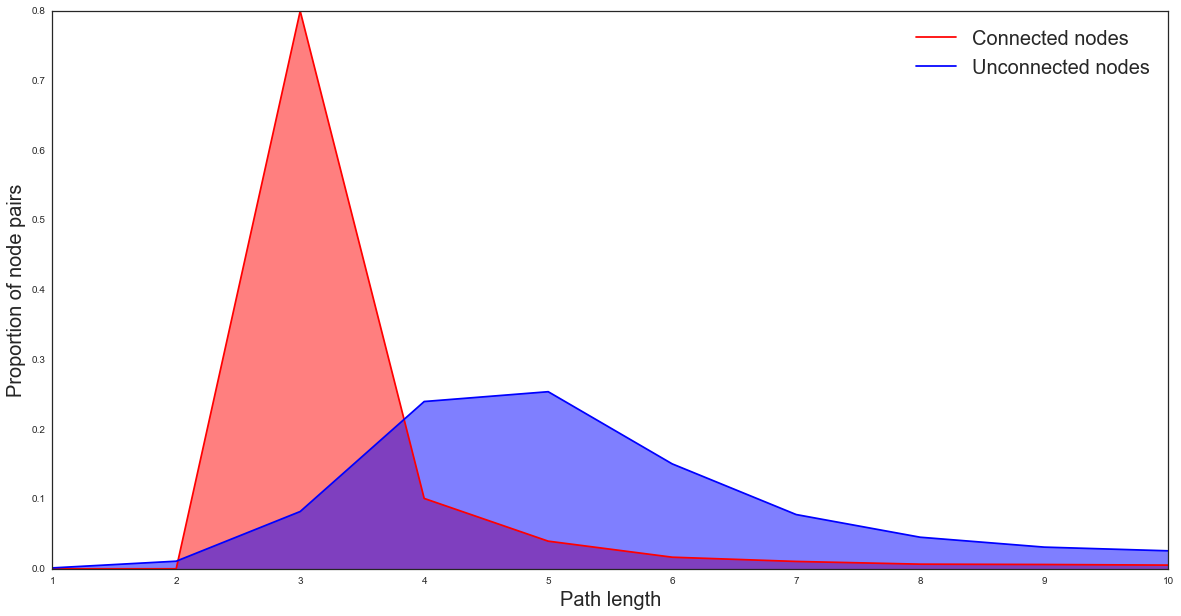

In [31]:
c.update({k:0 for k in c2.iterkeys() if k not in c.keys()})
a,b = (0,10)
x = c2.keys()[a:b]
non_edge_dist = [1.0*val/sum(c2.values()) for val in c2.values()]
edge_dist = [1.0*val/sum(c.values()) for val in c.values()]
plt.figure(figsize=(20,10))
p1, = plt.plot(x, edge_dist[a:b], label='Connected nodes', color="r")
plt.fill_between(x, edge_dist[a:b], color='r', alpha=0.5)
p2, = plt.plot(x, non_edge_dist[a:b], label='Unconnected nodes', color="b")
plt.fill_between(x, non_edge_dist[a:b], color='b', alpha=0.5)
plt.legend(handles=[p1,p2], fontsize=20, markerscale=5)
plt.ylabel('Proportion of node pairs', fontsize=20)
plt.xlabel('Path length', fontsize=20)

The distributions show that nodes that are connected more likely to share a neighbor node than unconnected nodes which is a good indicator that having common neighbors can be a good feature to include when predicting links in this network.

Several methods such as Adamic/Adar and Resource Allocation also weight the score of a link by the inverse of the nodes connecting the source and target based on that the higher the degree of a node, the less probability there is for it to be important that it two nodes both connect to it. This can be phrased as that $P((x,y)|(x,z),(y,z)) \propto \text{clustering}(z)$

In [14]:
clustering = nx.clustering(nx.Graph(GCC))
degree = nx.degree(nx.Graph(GCC))

In [28]:
cvd = {k: [] for k in range(0, max(GCC.degree(GCC.nodes()).values())+1)}
for node in clustering.iterkeys():
    i = degree[node]
    cvd[i].append(clustering[node])
cvd={k: sum(v)/len(v) for k,v in cvd.iteritems() if len(v) != 0}

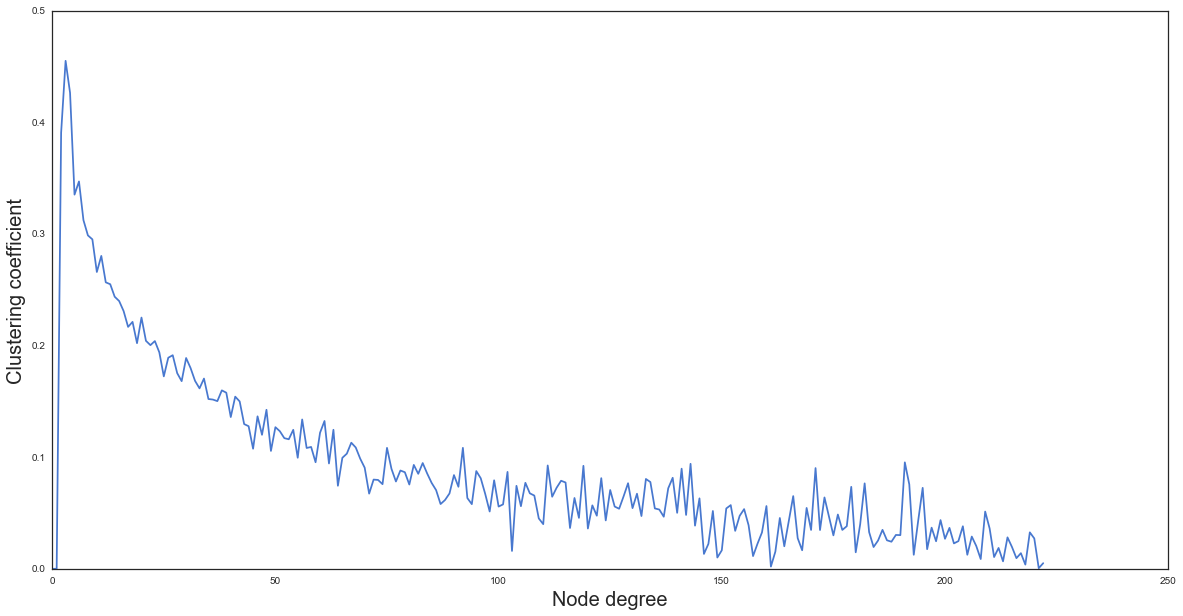

In [35]:
plt.figure(figsize=(20,10))
plt.plot(cvd.values())
plt.ylabel('Clustering coefficient', fontsize=20)
plt.xlabel('Node degree', fontsize=20)

It can also be relevant to look at the distribution of common referrers in the network, i.e. if we consider the link $(x,y)$, how many nodes exist in $V$ that both refer to $y$ and some node $z$ which is also referred to by $x$.

In [5]:
A = nx.adjacency_matrix(G)
B = nx.adjacency_matrix(nx.reverse(G, copy=True))

In [9]:
A[1,3]

0

In [12]:
C=A*B*A

In [18]:
C.nonzero()

(array([    0,     0,     1, ..., 16261, 16261, 16261]),
 array([ 7101,  4750, 13715, ...,  4462,  2885,  2246]))

Since I am going to be testing potential edges in the dataset it is interesting to know just how many nodes have potential links between them. A fully connected directed graph with $N$ nodes has $2N^2$ links, so the number of non edges can easily be found.

In [66]:
n = len(G)
e = len(G.edges())
print 'Number of nodes in G: {}'.format(n)
print 'Number of edges in G: {}'.format(e)
print 'Number of non-edges in G: {}'.format(2*(n**2-e))

Number of nodes in G: 16262
Number of edges in G: 96112
Number of non-edges in G: 528713064


Scoring all 18e7 non-edges in the graph would take a long time on my puny laptop, so already now it is clear that when testing different methods we will have to some kind of undersampling of the network.

The degree distribution can tell me a bit about the structure of the graph when plotted.

In [15]:
import matplotlib.pyplot as plt
from collections import *
%matplotlib inline

def plotLogDegree(graph):
	d_in = Counter(G.in_degree())
	y_in = Counter(d_in.values()).values()
	x_in = sorted(set(d_in.values()))
	d_out = Counter(G.out_degree())
	y_out = Counter(d_out.values()).values()
	x_out = sorted(set(d_out.values()))
	plt.loglog(x_in,y_in, 'ro-') # Plot the in degree distribution
	plt.loglog(x_out, y_out, 'bv-') # Plot the out degree distribution
	plt.xlabel('Degree')
	plt.ylabel('Number of nodes')
	plt.legend(['In degree', 'Out degree'])
	plt.legend()
	plt.show()

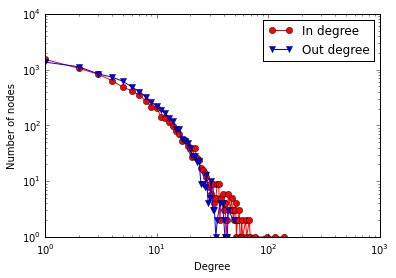

In [18]:
plotLogDegree(G)

The output of the graph is not so log linear that it instantly makes me think BA graph, but neither is it completely off. Time will tell. You'd think preferential attachment would be in effect since judges can only remember so many cases. Poco strane.

The connectivity of the components show that there is a single component with more than 8000 nodes and a bunch of smaller, unconnected components.

In [38]:
components = []
lengths = []
# Find the greatest component from the undirected version of the graph
for component in nx.connected_component_subgraphs(nx.Graph(G)):
    components.append(component)
    lengths.append(len(component))
    print "Length of component: {}".format(len(component))
# Find the GCC as the largest component and then recreate the directed graph
GCC = components[lengths.index(max(lengths))]
GCC = G.subgraph(GCC.nodes())

Length of component: 8574
Length of component: 1
Length of component: 1
Length of component: 3
Length of component: 1
Length of component: 2
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 2
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 2
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 2
Length of component: 1
Length of component: 2
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length of component: 1
Length o

It is possible that the GCC is closer to a BA graph than the full network. But in the this case it seems exactly the same

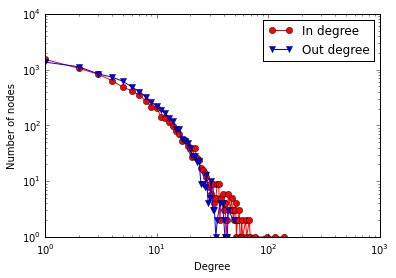

In [45]:
plotLogDegree(GCC)